<a href="https://colab.research.google.com/github/abhilasha-kumar/modeling-lexical-retrieval/blob/main/LexicalRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Allow drive access

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# GPU access

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Tue Dec  7 01:06:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    61W / 149W |    145MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import heapq
import itertools
import scipy.spatial.distance

import pandas as pd
import numpy as np

from numpy.random import randint
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler, normalize
from numpy.linalg import matrix_power
from functools import lru_cache
import glob
from scipy.special import expit

import matplotlib.pyplot as plt
import nltk
from functools import lru_cache
from itertools import product as iterprod
import itertools
from nltk.metrics import *
import re

# Importing Data

In [4]:
with tf.device('/device:GPU:0'):
  julie_files = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/Julie_2021data.csv", encoding= 'unicode_escape')
  vocab = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/julie_vocab.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
julie_files.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,StudyNo,AgeGroup,PrimeInstruction,ExperimentName,Subject,Procedure,Trial,Both,Neither,Phonological,Semantic,Prime,PrimeCondition,Question.RESP,State.RT,FreeResp,Resp,FreeResp.RT,NewAccuracy,Accuracy,FreeRespPrimeIntrusion,Target,MCCorrect,McResp,McAcc,McRT,a,b,c,d,e,McActualResp,WhichPrime,ToEliminate,prompt,both_prompt,neither_prompt,sem_prompt,phon_prompt,prime_prompt,target_prompt,resp_prompt,target_both,target_neither,target_sem,target_phon,target_prime,target_resp,lev_target_both,lev_target_neither,lev_target_sem,lev_target_phon,lev_target_prime,lev_target_resp
0,0,0,0,6,Old,NotThePrime,tot not the prime,701,ExpProc1,1,avoid,dove,absolve,refuse,ABSOLVE,P,2,0,0,12345,1527,0,0,0,abstain,c,NaN,0,0,refuse,dove,abstain,absolve,avoid,0,X,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.000,0.000,0.333333,0.333333,NaN
1,1,1,1,6,Old,NotThePrime,tot not the prime,701,ExpProc1,2,Norderstedt,image,neurosurgery,Berlin,NORDERSTEDT,B,2,6947,0,12345,1060,0,0,0,Nuremberg,d,d,1,7385,Norderstedt,Berlin,image,Nuremberg,neurosurgery,Nuremberg,0,0,German city for which antisemitic laws were na...,0.020833,-0.096533,0.164941,0.021730,0.020833,0.225719,NaN,0.180054,0.007681,0.428896,0.328091,0.180054,NaN,0.142857,0.125,0.000,0.333333,0.142857,NaN
2,2,2,2,6,Old,NotThePrime,tot not the prime,701,ExpProc1,3,hematoma,window,homeowner,contusion,HEMATOMA,B,4,5920,NaN,12345,0,0,0,0,hemorrhage,d,d,1,5430,hematoma,contusion,window,hemorrhage,homeowner,hemorrhage,0,0,"The escape of blood from vessels, including in...",0.155783,0.027197,0.066568,-0.063326,0.155783,0.326574,NaN,0.653506,0.210072,0.458587,0.151632,0.653506,NaN,0.375000,0.000,0.000,0.333333,0.375000,NaN
3,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.166060,0.144735,1.0,0.200000,0.000,0.200,0.500000,0.000000,1.0
4,4,4,4,6,Old,NotThePrime,tot not the prime,701,ExpProc1,5,Heinola,shop,handkerchief,Oslo,OSLO,R,1,7553,helsinki,Helsinki,3497,1,1,0,Helsinki,d,d,1,3366,Heinola,Oslo,shop,Helsinki,handkerchief,Helsinki,0,0,Capital of Finland,0.034701,-0.015010,0.383043,-0.002959,0.383043,0.575294,0.575294,0.222391,0.110593,0.546045,0.080330,0.546045,1.0,0.125000,0.000,0.125,0.125000,0.125000,1.0


# Import USE

The Universal Sentence Encoder uses two different architctures to encode a string of any length into a compact high-dimensional vector representation -- the Deep Averaging Network (which is more of a bag-of-words approach) and the Transformer network (more predictive, attention-based). See link above for more details -- but DAN is generally faster and slightly less accurate than the Transformer model on NLP tasks (we might want to compare both). Below we see some examples of how we can use these "vectors" to find "closest neighbors"

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
dan_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#transformer_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" 
model = hub.load(dan_url)
print ("module %s loaded" % dan_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
model(["Finland"])[0].shape

TensorShape([512])

In [6]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
sent1 = "Capital of Finland"
print("prompt is:", sent1)
sent1_vec = model([sent1])[0]
print("sent1_vec is a numpy array of shape:", sent1_vec.shape)
resp = list(vocab.vocab_word)
print(f"our vocab has {len(resp)} words from which we will find the ones closest to our sentence...")
cosine_list = [cosine(sent1_vec, model([r])[0]) for r in resp]
vocab["cosine"] = cosine_list
vocab.nlargest(10, "cosine")

prompt is: Capital of Finland
sent1_vec is a numpy array of shape: (512,)
our vocab has 12619 words from which we will find the ones closest to our sentence...


KeyboardInterrupt: ignored

In [ ]:
sent1 = "Last name of author of Little Women"
print("prompt is:", sent1)
sent1_vec = model([sent1])[0]
print("sent1_vec is a numpy array of shape:", sent1_vec.shape)
resp = list(vocab.vocab_word)
print(f"our vocab has {len(resp)} words from which we will find the ones closest to our sentence...")
cosine_list = [cosine(sent1_vec, model([r])[0]) for r in resp]
vocab["cosine"] = cosine_list
vocab.nlargest(10, "cosine")

prompt is: Last name of author of Little Women
sent1_vec is a numpy array of shape: (512,)
our vocab has 12619 words from which we will find the ones closest to our sentence...


,vocab_word,cosine
41,Alcott,0.387014
83,author,0.371520
11085,surname,0.349252
779,Rowling,0.270690
8518,petite,0.231320
780,runt,0.224465
7432,midget,0.220665
1944,biography,0.219154
12544,writer,0.217155
81,Austen,0.214192


In [ ]:
sent1 = "Instrument for performing calculations by sliding beads along rods or grooves"
print("prompt is:", sent1)
sent1_vec = model([sent1])[0]
print("sent1_vec is a numpy array of shape:", sent1_vec.shape)
resp = list(vocab.vocab_word)
print(f"our vocab has {len(resp)} words from which we will find the ones closest to our sentence...")
cosine_list = [cosine(sent1_vec, model([r])[0]) for r in resp]
vocab["cosine"] = cosine_list
vocab.nlargest(10, "cosine")

prompt is: Instrument for performing calculations by sliding beads along rods or grooves
sent1_vec is a numpy array of shape: (512,)
our vocab has 12619 words from which we will find the ones closest to our sentence...


,vocab_word,cosine
2,abacus,0.361816
148,calculations,0.336181
2405,calculation,0.305555
6389,instruments,0.305101
399,grooves,0.302247
12417,wind instrument,0.292259
104,beads,0.290021
6388,instrument,0.284906
471,Instrument,0.284906
7695,musical instrument,0.276964


The Transformer based USE model is pretty accurate in and of itself, whereas the DAN is not so accurate. But we want to model a "human" version of this model, so we can add some stochastic noise to these estimates for both models eventually

# Create phoneme function

Here we create a function that takes any letter string and partitions it into phonemes based on arpabet. Then we compute a measure of "normalized" phonemic similarity

In [7]:
# algo to obtain phonemes for any given strng
# obtained from: https://stackoverflow.com/questions/33666557/get-phonemes-from-any-word-in-python-nltk-or-other-modules
try:
    arpabet = nltk.corpus.cmudict.dict()
except LookupError:
    nltk.download('cmudict')
    arpabet = nltk.corpus.cmudict.dict()

@lru_cache()
def wordbreak(s):
    s = s.lower()
    if s in arpabet:
        return arpabet[s]
    middle = len(s)/2
    partition = sorted(list(range(len(s))), key=lambda x: (x-middle)**2-x)
    for i in partition:
        pre, suf = (s[:i], s[i:])
        if pre in arpabet and wordbreak(suf) is not None:
            return [x+y for x,y in iterprod(arpabet[pre], wordbreak(suf))]
    return None

def normalized_sim(w1, w2):
  return 1-edit_distance(w1,w2)/(max(len(w1), len(w2)))

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [ ]:
w1 = "bird"
w2 = "burden"
print("wordbreak(w1)[0]:",wordbreak(w1)[0])
print("wordbreak(w2)[0]:",wordbreak(w2)[0])

print("normalized orthographic similarity (letters):", normalized_sim(w1, w2))
print("normalized phonemic similarity:", normalized_sim(wordbreak(w1)[0],wordbreak(w2)[0]))

wordbreak(w1)[0]: ['B', 'ER1', 'D']
wordbreak(w2)[0]: ['B', 'ER1', 'D', 'AH0', 'N']
normalized orthographic similarity (letters): 0.5
normalized phonemic similarity: 0.6


## semantic 

Below we get cosines from the prompt to the different primes and targets in our data

In [ ]:
## get cosines for:
# 1. prompt - target
# 2. prompt - primes
# 3. prompt - resp

both_prompt = []
neither_prompt = []
phon_prompt = []
sem_prompt = []
prime_prompt = []
target_prompt = []
resp_prompt = []

# 4. target- primes
target_both = []
target_neither = []
target_sem = []
target_phon = []
target_prime = []
# 5. target - answer
target_resp = []


for index, row in julie_files.iterrows():
  prompt_vec = model([row["prompt"]])[0]
  target_vec = model([row["Target"]])[0]
  resp = re.sub('[^a-zA-Z]+', '', str(row["Resp"]))
  prime = str(row["Prime"])
  #print("resp =", resp)
  

  both_prompt_sim = cosine(prompt_vec, model([row["Both"]])[0])
  both_prompt.append(both_prompt_sim)

  neither_prompt_sim = cosine(prompt_vec, model([row["Neither"]])[0])
  neither_prompt.append(neither_prompt_sim)

  phon_prompt_sim = cosine(prompt_vec, model([row["Phonological"]])[0])
  phon_prompt.append(phon_prompt_sim)

  sem_prompt_sim = cosine(prompt_vec, model([row["Semantic"]])[0])
  sem_prompt.append(sem_prompt_sim)

  prime_prompt_sim = cosine(prompt_vec, model([prime])[0])
  prime_prompt.append(prime_prompt_sim)

  target_prompt_sim = cosine(prompt_vec, model([row["Target"]])[0])
  target_prompt.append(target_prompt_sim)
  
  resp_prompt_sim = cosine(prompt_vec, model([resp])[0]) if resp != "" else "NA"
  resp_prompt.append(resp_prompt_sim)
  

  #4. target- primes
  target_both_sim = cosine(target_vec, model([row["Both"]])[0])
  target_both.append(target_both_sim)

  target_neither_sim = cosine(target_vec, model([row["Neither"]])[0])
  target_neither.append(target_neither_sim)

  target_sem_sim = cosine(target_vec, model([row["Semantic"]])[0])
  target_sem.append(target_sem_sim)

  target_phon_sim = cosine(target_vec, model([row["Phonological"]])[0])
  target_phon.append(target_phon_sim)

  target_prime_sim = cosine(target_vec, model([prime])[0])
  target_prime.append(target_prime_sim)

  # 5. target - answer
  target_resp_sim = cosine(target_vec, model([resp])[0]) if resp != "" else "NA"
  target_resp.append(target_resp_sim)


julie_files["both_prompt"]  = both_prompt
julie_files["neither_prompt"]  = neither_prompt
julie_files["sem_prompt"]  = sem_prompt
julie_files["phon_prompt"]  = phon_prompt

julie_files["prime_prompt"]  = prime_prompt
julie_files["target_prompt"]  = target_prompt
julie_files["resp_prompt"]  = resp_prompt

julie_files["target_both"]  = target_both
julie_files["target_neither"]  = target_neither
julie_files["target_sem"]  = target_sem
julie_files["target_phon"]  = target_phon
julie_files["target_prime"]  = target_prime
julie_files["target_resp"]  = target_resp





KeyboardInterrupt: ignored

## phon

Below we get estimates of phonemic similarity from the prompt to the different primes and targets in our data

In [ ]:
## get normalized phonemic similarities for:

# 4. target- primes
target_both = []
target_neither = []
target_sem = []
target_phon = []
target_prime = []
# 5. target - answer
target_resp = []


for index, row in julie_files.iterrows():
  
  resp = re.sub('[^a-zA-Z]+', '', str(row["Resp"]))
  semantic = re.sub('[^a-zA-Z]+', '', str(row["Semantic"]))
  phono = re.sub('[^a-zA-Z]+', '', str(row["Phonological"]))
  neither = re.sub('[^a-zA-Z]+', '', str(row["Neither"]))
  both = re.sub('[^a-zA-Z]+', '', str(row["Both"]))
  

  prime = re.sub('[^a-zA-Z]+', '', str(row["Prime"]))
  #print("resp =", resp)
  

  #4. target- primes
  target_both_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(both)[0])
  target_both.append(target_both_sim)

  target_neither_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(neither)[0])
  target_neither.append(target_neither_sim)

  target_sem_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(semantic)[0])
  target_sem.append(target_sem_sim)

  target_phon_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(phono)[0])
  target_phon.append(target_phon_sim)

  target_prime_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(prime)[0])
  target_prime.append(target_prime_sim)

  # 5. target - answer
  target_resp_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(resp)[0]) if resp != "" else "NA"
  target_resp.append(target_resp_sim)

julie_files["lev_target_both"]  = target_both
julie_files["lev_target_neither"]  = target_neither
julie_files["lev_target_sem"]  = target_sem
julie_files["lev_target_phon"]  = target_phon
julie_files["lev_target_prime"]  = target_prime
julie_files["lev_target_resp"]  = target_resp





In [ ]:
julie_files.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/Julie_2021data.csv")

# Modeling Ideas

Some ways to think about how to "model" the task:


1. After obtaining the representation for the prompt and all words in the vocabulary, start an "activation" process such that at t = 0, activation "spreads" from the prompt to all words in proportion to their similarity to the prompt
2. At t=1, those words further spread activation to their neighbors.
3. This could continue for "t" time steps technically, but we can also introduce a prime at some time step. This "prime" gets some extra boost of activation (+5 units, say), and then similarities are assessed as a combination of prompt and cue to ultimately produce the response. 
4. Maybe the ideal way to do this is an "activation" matrix of size vocab x 1 for both semantic and phonology and then we merge the two eventually?
5. We may want to add in some stochastic noise to simulate partial knowledge in these models to see how that changes things
6. So a general process model might be:
*   activate_prompt_neighbors(noise) returns a 1-d array of similarities to every word in the vocab
*   activate_prime_neighbors(noise) returns two N-by-1 arrays of similarities+activation corresponding to semantic and phonological similarities
*   combine_semantic_phonological(method = "additive | multiplicative") returns a single N-by-1 array corresponding to combined sem-phon similarities after the promot and prime activations have been activated
*   generate_predictions() returns a softmax of the activated matrix
7. Ultimately, we want to make the code below efficient, and simulate about 100 participant runs with different levels of "noise" corresponding to levels of knowledge to obtain different model predictions
8. Also, we may want to have a parameter that controls the weight to semantic vs. phonological information in the "combine" function











## preparing/reducing data size

In [8]:
## preparing data
julie_files["ActualPrime"] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()
print(f"full dataset is {len(julie_files)} rows")
## for target accuracy we only need 100 (prompts) x 4 (primes)
targetacc_data = julie_files[["ActualPrime", "PrimeCondition", "Target", "prompt"]].drop_duplicates()
for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
  targetacc_data['AddPred' + str(i)] = np.nan
targetacc_data['MultPred'] = np.nan
print(f"target accuracy data is {len(targetacc_data)} rows")
## for response accuracy we need the unique responses for each prompt-prime combination

respacc_data = julie_files[["ActualPrime", "PrimeCondition", "Target", "Resp", "prompt"]].drop_duplicates()
print(f"response accuracy data is {len(respacc_data)} rows")

full dataset is 17400 rows
target accuracy data is 400 rows
response accuracy data is 4377 rows


In [9]:
## we reshape the data so that we can run the functions at the "prompt" level
respacc_data = respacc_data.sort_values(by=['prompt'])
resp_wide = respacc_data.pivot(index = ["prompt", "Target", "Resp"], columns = ["PrimeCondition"], values = ["ActualPrime"])
resp_wide = resp_wide.reset_index()
resp_wide.columns = resp_wide.columns.map('|'.join).str.strip('|')
resp_wide = resp_wide[resp_wide.Resp != '12345']
resp_wide = resp_wide.reset_index()
for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
  resp_wide['AddPred' + str(i)] = np.nan
resp_wide['MultPred'] = np.nan
resp_wide

,index,prompt,Target,Resp,ActualPrime|B,ActualPrime|P,ActualPrime|R,ActualPrime|U,AddPred0,AddPred0.1,AddPred0.2,AddPred0.3,AddPred0.4,AddPred0.5,AddPred0.6,AddPred0.7,AddPred0.8,AddPred0.9,AddPred1,MultPred
0,1,20th century American poet whose trademark was...,Cummings,Browning,NaN,NaN,Browning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,20th century American poet whose trademark was...,Cummings,Carrol,NaN,cummerbund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,20th century American poet whose trademark was...,Cummings,Cummings,Cunningham,cummerbund,Browning,point,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,20th century American poet whose trademark was...,Cummings,Cunnigham,Cunningham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,20th century American poet whose trademark was...,Cummings,Dickinson,Cunningham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,2765,Word made by changing the order of letters in ...,anagram,palindrome,acronym,analytic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2666,2766,Word made by changing the order of letters in ...,anagram,plenumbra,acronym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2667,2767,Word made by changing the order of letters in ...,anagram,puzzle,NaN,NaN,puzzle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2668,2768,Word made by changing the order of letters in ...,anagram,synonym,acronym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Computing all vectors

In [ ]:
type(targetacc_data['AddPrediction'][0]) == float

True

In [ ]:
def vectors(data, vocab):
  prompts = pd.Series(data["prompt"].unique())
  p_vecs = np.array([model([x])[0].numpy() for x in prompts])
  print(p_vecs.shape)

  p_vectors_df = pd.DataFrame(p_vecs).transpose()
  print(p_vectors_df.shape)
  p_vectors_df.columns = prompts
  print(p_vectors_df.head())
  p_vectors_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/PromptVectors_New.csv", index = False)

  words = list(vocab.vocab_word)
  w_vecs = np.array([model([x])[0].numpy() for x in words])
  print(w_vecs.shape)
  w_vectors_df = pd.DataFrame(w_vecs).transpose()

  print(w_vectors_df.shape)
  w_vectors_df.columns = words
  print(w_vectors_df.head())
  w_vectors_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/VocabVectors_New.csv", index = False)

vectors(targetacc_data, vocab)


(100, 512)
(512, 100)
   To refrain deliberately and often with an effort of self-denial from an action or practice  ...  Happening by a lucky chance or by accident rather than by design
0                                           0.014262                                           ...                                          -0.002915               
1                                           0.018321                                           ...                                          -0.052756               
2                                           0.026393                                           ...                                          -0.002790               
3                                          -0.029389                                           ...                                           0.019612               
4                                           0.018353                                           ...                                           0.037026    

In [10]:
prompt_vectors = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/PromptVectors_New.csv")
print(prompt_vectors.shape)
vocab_vectors = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/VocabVectors_New.csv")
print(vocab_vectors.shape)

(512, 100)
(512, 12619)


In [ ]:
vocab_vectors['finland']

KeyError: ignored

In [ ]:
#type(prompt_vectors.loc[prompt_vectors['prompt'] == 'Capital of Finland']['vector'])
#type(vocab_vectors['vector'][1])
#type(model(['Finland'])[0].numpy())
#vocab_vectors.dtypes
cosine(prompt_vectors['Capital of Finland'].values, vocab_vectors['Finland'].values)


0.6351254414789951

## model functions

In [11]:
def initial_activation(vocab_words):
  # returns an array of initial activations, currently zero, but eventually replace by word frequency
  x = np.zeros((len(vocab_words),1)).T
  return x

initial_activation(vocab).shape

(1, 12619)

In [12]:
def activate_prompt_neighbors(activations, prompt, noise_level):
  ## takes in a 1-d array of current activations
  ## computes a vector representation of the prompt and returns a vector of similarities to each word in vocab + activations
  ## with some noise added to each estimate
  noise = np.random.normal(0, noise_level, 1)
  prompt_vec = prompt_vectors[prompt].values
  resp = vocab_vectors.columns
  cosine_list = np.array([cosine(prompt_vec, vocab_vectors[r].values) for r in resp]) + activations # eventually add noise
  return cosine_list

#x = activate_prompt_neighbors(initial_activation(vocab), "Capital of Finland", 0.1)

In [13]:
def activate_prime_neighbors(activations_sem, prime):
  ## takes in a 1-d array of semantic activations and returns "primed" activations for both semantic and phonological
  prime_vec = vocab_vectors[prime].values
  resp = vocab_vectors.columns
  semantic = np.array([cosine(prime_vec, vocab_vectors[r].values) for r in resp]) + activations_sem
  phon = np.array([normalized_sim(r, prime) for r in resp]).reshape(semantic.shape)
  assert semantic.shape == phon.shape
  return semantic, phon

#y, z = activate_prime_neighbors(x, 'Oslo')

In [14]:
def combine_semantic_phonological(semantic, phonological, method = "multiply", alpha=0): 
  if method == "add":
    wtds = alpha * semantic
    wtdp = (1-alpha)*phonological
    comb = np.add(wtds, wtdp)
  else:
    comb = np.multiply(semantic, phonological)
  
  return softmax(comb)

#final_activations = combine_semantic_phonological(y, z, "add", 0.1)

In [15]:
def generate_predictions(activations, vocab_words, topn = 10):
  ## takes in final activations and generates the top10 predictions
  return [list(vocab_words.vocab_word)[i] for i in np.argpartition(-activations, topn).flatten().tolist()[:topn]]

#generate_predictions(final_activations, vocab, topn = 10)

In [16]:
def lexical_retrieval_model(prompt, prime, vocab_words, alpha):
  ## brings all functions together
  init = initial_activation(vocab_words)
  x = activate_prompt_neighbors(init, vocab_words, prompt, 0.1)
  y, z = activate_prime_neighbors(x, vocab, prime)
  final_add = combine_semantic_phonological(y, z, "add", alpha)
  final_mult = combine_semantic_phonological(y, z, "multiply")
  preds_add = generate_predictions(final_add, vocab_words, topn = 10)
  preds_mult = generate_predictions(final_mult, vocab_words, topn = 10)

  return preds_add, preds_mult

## to-do

1. now we should use the "wide" dataset above and run activate_prompt_neigbors only ONCE for each prompt 
2. so dont use the lexical_retrieval_model function but instead use the base functions (activate_prompt_neighbors etc.) by looping over the above dataset in a way that the prompt activation function is called only once and then you calculate the differnet prime activations for that same prompt activation array
3. Let's just do this for alpha = 0.5 for now to see initial results 


# Response accuracy

In [ ]:
resp_wide

,index,prompt,Target,Resp,ActualPrime|B,ActualPrime|P,ActualPrime|R,ActualPrime|U,AddPred0,AddPred0.1,AddPred0.2,AddPred0.3,AddPred0.4,AddPred0.5,AddPred0.6,AddPred0.7,AddPred0.8,AddPred0.9,AddPred1,MultPred
0,1,20th century American poet whose trademark was...,Cummings,Browning,NaN,NaN,Browning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,20th century American poet whose trademark was...,Cummings,Carrol,NaN,cummerbund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,20th century American poet whose trademark was...,Cummings,Cummings,Cunningham,cummerbund,Browning,point,"[stunning, running, cunning, sunlight, Cumming...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,20th century American poet whose trademark was...,Cummings,Cunnigham,Cunningham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,20th century American poet whose trademark was...,Cummings,Dickinson,Cunningham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,2765,Word made by changing the order of letters in ...,anagram,palindrome,acronym,analytic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2666,2766,Word made by changing the order of letters in ...,anagram,plenumbra,acronym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2667,2767,Word made by changing the order of letters in ...,anagram,puzzle,NaN,NaN,puzzle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2668,2768,Word made by changing the order of letters in ...,anagram,synonym,acronym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
r_acc = {'prompt': [],'PrimeCond': [], 'prime': [], 'Resp': [], 'alpha': [], 'n': [], 'modelType': [],'RespAcc': []}
t_acc = {'prompt': [],'PrimeCond': [], 'prime': [], 'alpha': [], 'n': [], 'modelType': [],'TargAcc': []}
prompt_acts = {}
prime_acts = {}
def accuracy_single(t, vocab_words, n, alpha, pc):
  # adds 1 to corresponding list if the response/target is in the top n predictions, else 0
  #target accuracy
  global t_acc_df
  global r_acc_df
  # if t < len(targetacc_data.index) and pc == targetacc_data["PrimeCondition"][t]: 
  #   if type(targetacc_data["AddPred"+str(alpha)][t]) != list:
  #     if targetacc_data["prompt"][t] not in prompt_acts:
  #       init = initial_activation(vocab_words)
  #       prompt_neighbors = activate_prompt_neighbors(init, targetacc_data["prompt"][t], 0.1)
  #       prompt_acts[targetacc_data["prompt"][t]] = prompt_neighbors
  #     else:
  #       prompt_neighbors = prompt_acts[targetacc_data["prompt"][t]]

  #     if targetacc_data["ActualPrime"][t] not in prime_acts:
  #       a, b = activate_prime_neighbors(prompt_neighbors, targetacc_data["ActualPrime"][t])
  #       prime_acts[targetacc_data["ActualPrime"][t]] = (a, b)
  #     else:
  #       a, b = prime_acts[targetacc_data["ActualPrime"][t]]
  #     final_add = combine_semantic_phonological(a, b, "add", alpha)
  #     targetacc_data["AddPred"+str(alpha)][t] = generate_predictions(final_add, vocab_words, 20)
  #     if type(targetacc_data["MultPred"][t]) != list:
  #       final_mult = combine_semantic_phonological(a, b, "multiply")
  #       targetacc_data["MultPred"][t] = generate_predictions(final_mult, vocab_words, 20)

  #   success = 1 if targetacc_data["Target"][t] in targetacc_data["AddPred"+str(alpha)][t][:n] else 0
  #   t_acc["prompt"].append(targetacc_data["prompt"][t])
  #   t_acc["PrimeCond"].append(pc)
  #   t_acc["prime"].append(targetacc_data["ActualPrime"][t])
  #   t_acc["alpha"].append(alpha)
  #   t_acc["n"].append(n)
  #   t_acc["modelType"].append('add')
  #   t_acc["TargAcc"].append(success)
  #   success = 1 if targetacc_data["Target"][t] in targetacc_data["MultPred"][t][:n] else 0
  #   t_acc["prompt"].append(targetacc_data["prompt"][t])
  #   t_acc["PrimeCond"].append(pc)
  #   t_acc["prime"].append(targetacc_data["ActualPrime"][t])
  #   t_acc["alpha"].append(alpha)
  #   t_acc["n"].append(n)
  #   t_acc["modelType"].append('mult')
  #   t_acc["TargAcc"].append(success)

  #response accuracy
  col = "ActualPrime|" + pc
  if  pd.notna(resp_wide[col][t]):
    if type(resp_wide["AddPred" + str(alpha)][t]) != list:
      if resp_wide["prompt"][t] not in prompt_acts:
        init = initial_activation(vocab_words)
        prompt_neighbors = activate_prompt_neighbors(init, resp_wide["prompt"][t], 0.1)
        prompt_acts[resp_wide["prompt"][t]] = prompt_neighbors
      else:
        prompt_neighbors = prompt_acts[resp_wide["prompt"][t]]
      
      if resp_wide[col][t] not in prime_acts:
        a, b = activate_prime_neighbors(prompt_neighbors, resp_wide[col][t])
        prime_acts[resp_wide[col][t]] = (a, b)
      else:
        a, b = prime_acts[resp_wide[col][t]]
        
      final_add = combine_semantic_phonological(a, b, "add", alpha)
      resp_wide["AddPred"+str(alpha)][t] = generate_predictions(final_add, vocab_words, 20)
      if type(resp_wide["MultPred"][t]) != list:
        final_mult = combine_semantic_phonological(a, b, "multiply")
        resp_wide["MultPred"][t] = generate_predictions(final_mult, vocab_words, 20)

    success = 1 if resp_wide["Resp"][t].lower() in (pred.lower() for pred in resp_wide["AddPred"+str(alpha)][t][:n]) else 0
    r_acc["prompt"].append(resp_wide["prompt"][t])
    r_acc["PrimeCond"].append(pc)
    r_acc["prime"].append(resp_wide[col][t])
    r_acc["Resp"].append(resp_wide["Resp"][t])
    r_acc["alpha"].append(alpha)
    r_acc["n"].append(n)
    r_acc["modelType"].append('add')
    r_acc["RespAcc"].append(success)
    success = 1 if resp_wide["Resp"][t].lower() in (pred.lower() for pred in resp_wide["MultPred"][t][:n]) else 0
    r_acc["prompt"].append(resp_wide["prompt"][t])
    r_acc["PrimeCond"].append(pc)
    r_acc["prime"].append(resp_wide[col][t])
    r_acc["Resp"].append(resp_wide["Resp"][t])
    r_acc["alpha"].append(alpha)
    r_acc["n"].append(n)
    r_acc["modelType"].append('mult')
    r_acc["RespAcc"].append(success)

def accuracy_overall(vocab_words, n, alpha, pc):
  # returns the overall probability that the response will appear in the top n words predicted by the model
  for t in range(len(resp_wide.index)):
    accuracy_single(t, vocab_words, n, alpha, pc)


In [21]:
# create dataframe of response & target accuracies for all alpha values, n 1-20, for each prime condition, 
# for additive and multiplicative model
alpha = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
nums = range(1,21)
pc = ['B', 'P', 'R', 'U']
for p in pc:
  for a in alpha:
    for n in nums:
      accuracy_overall(vocab, n, a, p)
    print("Completed with alpha", a)

#r_acc_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseAccuracy.csv", index = False)
#t_acc_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/TargetAccuracy.csv", index = False)

Completed with alpha 0
Completed with alpha 0.1
Completed with alpha 0.2
Completed with alpha 0.3
Completed with alpha 0.4
Completed with alpha 0.5
Completed with alpha 0.6
Completed with alpha 0.7
Completed with alpha 0.8
Completed with alpha 0.9
Completed with alpha 1
Completed with alpha 0
Completed with alpha 0.1
Completed with alpha 0.2
Completed with alpha 0.3
Completed with alpha 0.4
Completed with alpha 0.5
Completed with alpha 0.6
Completed with alpha 0.7
Completed with alpha 0.8
Completed with alpha 0.9
Completed with alpha 1
Completed with alpha 0
Completed with alpha 0.1
Completed with alpha 0.2
Completed with alpha 0.3
Completed with alpha 0.4
Completed with alpha 0.5
Completed with alpha 0.6
Completed with alpha 0.7
Completed with alpha 0.8
Completed with alpha 0.9
Completed with alpha 1
Completed with alpha 0
Completed with alpha 0.1
Completed with alpha 0.2
Completed with alpha 0.3
Completed with alpha 0.4
Completed with alpha 0.5
Completed with alpha 0.6
Completed with

In [22]:
r_acc_df = pd.DataFrame.from_dict(r_acc)
#t_acc_df = pd.DataFrame.from_dict(t_acc)

In [ ]:
t_acc_df

,prompt,PrimeCond,prime,alpha,n,modelType,TargAcc
0,German city for which antisemitic laws were named,B,Norderstedt,0.0,1,add,0
1,German city for which antisemitic laws were named,B,Norderstedt,0.0,1,mult,0
2,"The escape of blood from vessels, including in...",B,hematoma,0.0,1,add,0
3,"The escape of blood from vessels, including in...",B,hematoma,0.0,1,mult,0
4,Having unlimited power; able to do anything,B,omniscient,0.0,1,add,0
...,...,...,...,...,...,...,...
175995,Last name of author of Little Women,U,truck,1.0,20,mult,0
175996,A small lizard with skin that changes color to...,U,bagel,1.0,20,add,1
175997,A small lizard with skin that changes color to...,U,bagel,1.0,20,mult,0
175998,Something out of keeping with the time in whic...,U,view,1.0,20,add,0


### grouping and plotting

In [ ]:
x = t_acc_df[['PrimeCond', 'TargAcc','alpha', 'n']].groupby(['PrimeCond','alpha', 'n']).mean()

TargAcc
PrimeCond alpha n          
B         0.0   1     0.035
                2     0.085
                3     0.100
                4     0.135
                5     0.165
...                     ...
U         1.0   16    0.105
                17    0.120
                18    0.135
                19    0.140
                20    0.150

[880 rows x 1 columns]

In [23]:
r_acc_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseAccuracy.csv", index = False)
#t_acc_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/TargetAccuracy.csv", index = False)

In [24]:
r_acc_df = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseAccuracy.csv")
t_acc_df = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/TargetAccuracy.csv")
full_acc_df = pd.merge(r_acc_df, t_acc_df, how = 'left', on = ['prompt', 'PrimeCond', 'prime', 'alpha', 'n', 'modelType'])
full_acc_df.rename(columns = {'PrimeCond': 'PrimeCondition'}, inplace = True)


In [25]:
r_acc_df

,prompt,PrimeCond,prime,Resp,alpha,n,modelType,RespAcc
0,20th century American poet whose trademark was...,B,Cunningham,Cummings,0.0,1,add,0
1,20th century American poet whose trademark was...,B,Cunningham,Cummings,0.0,1,mult,0
2,20th century American poet whose trademark was...,B,Cunningham,Cunnigham,0.0,1,add,0
3,20th century American poet whose trademark was...,B,Cunningham,Cunnigham,0.0,1,mult,0
4,20th century American poet whose trademark was...,B,Cunningham,Dickinson,0.0,1,add,0
...,...,...,...,...,...,...,...,...
1749875,Word made by changing the order of letters in ...,U,chute,acrostic,1.0,20,mult,0
1749876,Word made by changing the order of letters in ...,U,chute,anagram,1.0,20,add,1
1749877,Word made by changing the order of letters in ...,U,chute,anagram,1.0,20,mult,1
1749878,Word made by changing the order of letters in ...,U,chute,palendrome,1.0,20,add,0


In [ ]:
prompt, primecondition, prime, resp

4875200

In [26]:
# merge accuracy data with julie_files on prompt and PrimeCondition columns
julie_files = julie_files.merge(full_acc_df, how = 'outer', on = ['prompt', 'PrimeCondition', 'Resp'])

In [27]:
julie_files

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,StudyNo,AgeGroup,PrimeInstruction,ExperimentName,Subject,Procedure,Trial,Both,Neither,Phonological,Semantic,Prime,PrimeCondition,Question.RESP,State.RT,FreeResp,Resp,FreeResp.RT,NewAccuracy,Accuracy,FreeRespPrimeIntrusion,Target,MCCorrect,McResp,McAcc,McRT,a,b,c,d,e,McActualResp,WhichPrime,ToEliminate,prompt,both_prompt,neither_prompt,sem_prompt,phon_prompt,prime_prompt,target_prompt,resp_prompt,target_both,target_neither,target_sem,target_phon,target_prime,target_resp,lev_target_both,lev_target_neither,lev_target_sem,lev_target_phon,lev_target_prime,lev_target_resp,ActualPrime,prime,alpha,n,modelType,RespAcc,TargAcc
0,0,0,0,6,Old,NotThePrime,tot not the prime,701,ExpProc1,1,avoid,dove,absolve,refuse,ABSOLVE,P,2,0,0,12345,1527,0,0,0,abstain,c,NaN,0,0,refuse,dove,abstain,absolve,avoid,0,X,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.0,0.0,0.333333,0.333333,NaN,absolve,NaN,NaN,NaN,NaN,NaN,NaN
1,863,863,863,6,Old,NotThePrime,tot not the prime,709,ExpProc1,64,avoid,dove,absolve,refuse,ABSOLVE,P,2,1969,0,12345,123,0,0,0,abstain,c,c,1,3637,refuse,dove,abstain,absolve,avoid,abstain,0,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.0,0.0,0.333333,0.333333,NaN,absolve,NaN,NaN,NaN,NaN,NaN,NaN
2,1954,1954,1954,6,Old,NotThePrime,tot not the prime,721,ExpProc1,55,avoid,dove,absolve,refuse,ABSOLVE,P,2,4106,0,12345,194,0,0,0,abstain,c,c,1,3690,refuse,dove,abstain,absolve,avoid,abstain,0,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.0,0.0,0.333333,0.333333,NaN,absolve,NaN,NaN,NaN,NaN,NaN,NaN
3,3024,3024,3024,6,Old,NotThePrime,tot not the prime,733,ExpProc1,25,avoid,dove,absolve,refuse,ABSOLVE,P,2,9819,0,12345,288,0,0,0,abstain,c,e,0,8729,refuse,dove,abstain,absolve,avoid,avoid,B,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.0,0.0,0.333333,0.333333,NaN,absolve,NaN,NaN,NaN,NaN,NaN,NaN
4,3886,3886,3886,5,Young,NotThePrime,tot not the prime,169,ExpProc1,87,avoid,dove,absolve,refuse,ABSOLVE,P,4,3203,NaN,12345,462,0,0,0,abstain,e,e,1,2517,dove,avoid,absolve,refuse,abstain,abstain,0,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.0,0.0,0.333333,0.333333,NaN,absolve,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347252,17397,17397,17397,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,98,Wilson,ball,wattage,Doyle,Wilson,B,1,5276,{SHIFT}Wagner{SPACE},Wagner,2528,0,0,NaN,Watson,a,a,1,3346,Watson,wattage,Doyle,Wilson,ball,Watson,0,0,Last name of Sherlock Holmes' assistant and fr...,0.158221,0.101450,0.342255,-0.037300,0.158221,0.350901,0.116549,0.406117,0.331885,0.525539,0.148385,0.406117,0.27318,0.666667,0.0,0.0,0.666667,0.666667,0.166667,Wilson,Wilson,1.0,18.0,mult,0.0,1.0
4347253,17397,17397,17397,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,98,Wilson,ball,wattage,Doyle,Wilson,B,1,5276,{SHIFT}Wagner{SPACE},Wagner,2528,0,0,NaN,Watson,a,a,1,3346,Watson,wattage,Doyle,Wilson,ball,Watson,0,0,Last name of Sherlock Holmes' assistant and fr...,0.158221,0.101450,0.342255,-0.037300,0.158221,0.350901,0.116549,0.406117,0.331885,0.525539,0.148385,0.406117,0.27318,0.666667,0.0,0.0,0.666667,0.666667,0.166667,Wilson,Wilson,1.0,19.0,add,0.0,1.0
4347254,17397,17397,17397,1,Young,NoInstructio

In [28]:
len(julie_files)

4347257

In [29]:
julie_files.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/Julie_2021data_merged.csv")

In [ ]:
both = julie_files.loc[julie_files['PrimeCondition']=='B', ['alpha', 'n', 'modelType', 'RespAcc', 'TargAcc']]
phonological = julie_files.loc[julie_files['PrimeCondition']=='P', ['alpha', 'n', 'modelType', 'RespAcc', 'TargAcc']]
semantic = julie_files.loc[julie_files['PrimeCondition']=='R', ['alpha', 'n', 'modelType', 'RespAcc', 'TargAcc']]
neither = julie_files.loc[julie_files['PrimeCondition']=='U', ['alpha', 'n', 'modelType', 'RespAcc', 'TargAcc']]

In [44]:
x = julie_files[['PrimeCondition', 'alpha', 'n','TargAcc', 'RespAcc', 'modelType']].groupby(['PrimeCondition','alpha', 'n', 'modelType']).mean()

In [51]:
x.loc['B'].columns

Index(['TargAcc', 'RespAcc'], dtype='object')

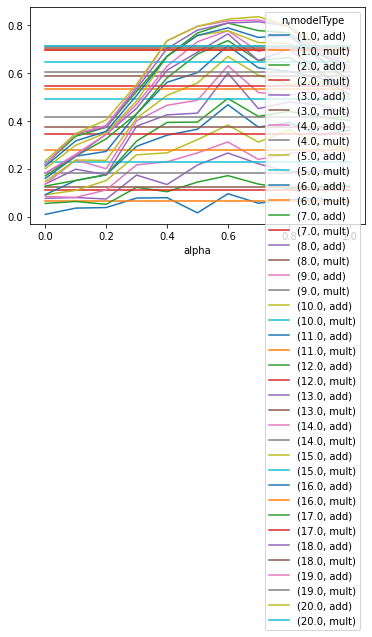

In [53]:
#test unstack plotting
both = x.loc['B']
both['TargAcc'].unstack([-2, -1]).plot()
plt.show()

In [ ]:
# plots
participant_acc = julie_files[["PrimeCondition", "NewAccuracy"]].groupby(["PrimeCondition"]).mean() #group by pc
def make_plots(pc, acctype):
  if acctype == "r":
    colnm = "RespAcc"
    title = "Response"
  else if acctype == "t":
    colnm = "TargAcc"
    title = "Target"
  else: 
    print("acctype must be 'r' or 't'")
    return

  for i in range(21):
    add = pc[(pc['n'] == i) & (pc['modelType' == 'add'])]
    mult = pc[(pc['n'] == i) & (pc['modelType' == 'mult'])]
    plt.plot(alpha, add[colnm].mean(), label = "n="+str(i)+", add.", linestyle = "-") # change y to be a list that varies with alpha
    plt.plot(alpha, mult[colnm].mean(), label = "n="+str(i)+", mult.", linestyle = ":")
  plt.plot(alpha, participant_acc.get_group(pc), label = "Participant accuracy", linestyle = "-.")
  plt.legend()
  plt.title(title+" Accuracy Both Primes")
  plt.show()

# Old stuff

Completed with n 1
Completed with n 2
Completed with n 3
Completed with n 4
Completed with n 5
Completed with n 6
Completed with n 7
Completed with n 8
Completed with n 9
Completed with n 10
Completed with n 11
Completed with n 12
Completed with n 13
Completed with n 14
Completed with n 15
Completed with n 16
Completed with n 17
Completed with n 18
Completed with n 19
Completed with n 20


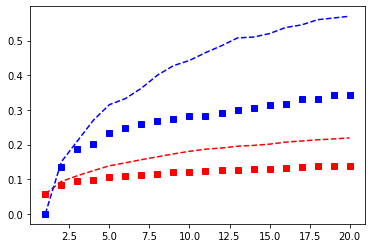

In [ ]:
# plot response and target accuracy together with varying n's, alpha = .8
rAdd = []
rMult = []
tAdd = []
tMult = []
x = range(1,21)
for i in x:
  acc = accuracy_overall(vocab, i, 0.8)
  rAdd.append(acc[0])
  rMult.append(acc[1])
  tAdd.append(acc[2])
  tMult.append(acc[3])
  print("Completed with n", i)

plt.plot(x, rAdd, 'r--', x, rMult, 'rs', x, tAdd, 'b--', x, tMult, 'bs')

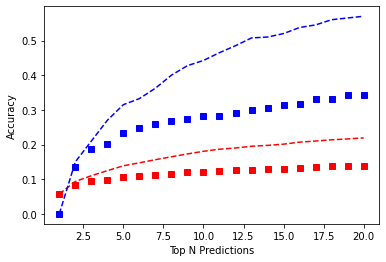

In [ ]:
plt.plot(x, rAdd, 'r--', x, rMult, 'rs', x, tAdd, 'b--', x, tMult, 'bs')
plt.xlabel("Top N Predictions")
plt.ylabel("Accuracy")
plt.show()

Accuracy of additive model: 0.07744531053557958
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.0
Accuracy of additive model: 0.08901181795323108
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.1
Accuracy of additive model: 0.09504651747548404
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.2
Accuracy of additive model: 0.10611013326628112
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.30000000000000004
Accuracy of additive model: 0.1249685692733216
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.4
Accuracy of additive model: 0.14382700528036207
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.5
Accuracy of additive model: 0.16117676640683934
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.6000000000000001
Accuracy of additive model: 0.17374905707819965
Accuracy of multiplicative model:

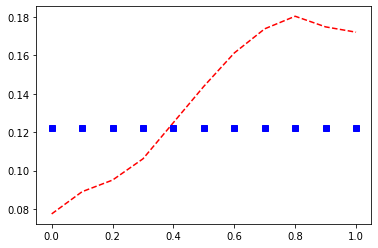

In [ ]:
# plot accuracy as a function of n or alpha for both add and mult 
#nvals = [i for i in range(5, 11)] #change upper bound depending on value of topn used in generate_predictions()
#plt.plot(nvals, accuracy_overall(vocab, nvals)[0], 'r--', nvals, accuracy_overall(vocab, nvals)[1]) 
a = [x * 0.1 for x in range(11)]
yAdd = []
yMult = []
for i in a:
  acc = accuracy_overall(vocab, 10, i, resp_wide)
  yAdd.append(acc[0])
  yMult.append(acc[1])
  print("Completed with alpha", i)

plt.plot(a, yAdd, 'r--', a, yMult, 'bs')
plt.show()

# Measure target accuracy


In [ ]:
targetacc_data

,ActualPrime,PrimeCondition,Target,prompt
0,absolve,P,abstain,To refrain deliberately and often with an effo...
1,Norderstedt,B,Nuremberg,German city for which antisemitic laws were named
2,hematoma,B,hemorrhage,"The escape of blood from vessels, including in..."
3,thigh,U,Seoul,Capital of South Korea
4,Oslo,R,Helsinki,Capital of Finland
...,...,...,...,...
395,terse,B,taciturn,"Saying little, reserved, uncommunicative"
396,bagel,U,chameleon,A small lizard with skin that changes color to...
397,Sardinia,B,Sicily,The largest Mediterranean island; the Italian ...
398,Shelley,B,Shaw,Last name of Irish author well known for Pygma...


In [ ]:
saved_prompt_acts = prompt_acts
saved_prime_acts = prime_acts

In [ ]:
# modify functions for targetacc_data
targ_add_success = []
targ_mult_success = []
def targ_acc_single(t, vocab_words, n, alpha, data):
  prompt_neighbors = saved_prompt_acts[data["prompt"][t]]
  if data["ActualPrime"][t] not in saved_prime_acts:
    a, b = activate_prime_neighbors(prompt_neighbors, data["ActualPrime"][t])
    saved_prime_acts[data["ActualPrime"][t]] = (a, b)
  else:
    a, b = saved_prime_acts[data["ActualPrime"][t]]
  final_add = combine_semantic_phonological(a, b, "add", alpha)
  final_mult = combine_semantic_phonological(a, b, "multiply")
  preds_add = generate_predictions(final_add, vocab_words, topn = 10)
  preds_mult = generate_predictions(final_mult, vocab_words, topn = 10)
  if data["Target"][t] in preds_add[:n]:
    targ_add_success.append(1)
  else:
    targ_add_success.append(0)
  if data["Target"][t] in preds_mult[:n]:
    targ_mult_success.append(1)
  else:
    targ_mult_success.append(0)

def targ_acc_overall(vocab_words, n, alpha, data):
  # returns the overall probability that the target will appear in the top n words predicted by the model
  targ_add_success.clear()
  targ_mult_success.clear()
  for t in range(len(data.index)):
    targ_acc_single(t, vocab_words, n, alpha, data)
  acc_add = np.mean(targ_add_success)
  acc_mult = np.mean(targ_mult_success)
  print("Accuracy of additive model:", acc_add)
  print("Accuracy of multiplicative model:", acc_mult)
  return acc_add, acc_mult

Accuracy of additive model: 0.0825
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.0
Accuracy of additive model: 0.1375
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.1
Accuracy of additive model: 0.1725
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.2
Accuracy of additive model: 0.23
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.30000000000000004
Accuracy of additive model: 0.2925
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.4
Accuracy of additive model: 0.355
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.5
Accuracy of additive model: 0.4075
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.6000000000000001
Accuracy of additive model: 0.44
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.7000000000000001
Accuracy of additive model: 0.4425
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.8
Accuracy of additive model: 0.41
Accuracy of multi

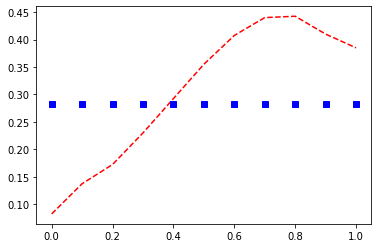

In [ ]:
targAdd = []
targMult = []
for i in a:
  acc = targ_acc_overall(vocab, 10, i, targetacc_data)
  targAdd.append(acc[0])
  targMult.append(acc[1])
  print("Completed with alpha", i)

plt.plot(a, targAdd, 'r--', a, targMult, 'bs')
plt.show()

More plots

NameError: ignored

# model predictions: examples

In [ ]:
add, mult = lexical_retrieval_model("Capital of Finland", "Helsinki", vocab)
print("predictions for additive model:", add)
print("predictions for multiplicative model:", mult)

predictions for additive model: ['Helsinki', 'Finland', 'Czechoslovakia', 'Oslo', 'Nordic', 'Sweden', 'Berlin', 'Holland', 'Iceland', 'Celtic']
predictions for multiplicative model: ['Holland', 'Czechoslovakia', 'Berlin', 'Celtic', 'Helsinki', 'ski', 'Alpine', 'herring', 'Pilsen', 'clingy']


In [ ]:
add, mult = lexical_retrieval_model("A mathematical expression consisting of two terms", "bilateral", vocab)
print("predictions for additive model:", add)
print("predictions for multiplicative model:", mult)

predictions for additive model: ['biannual', 'bilateral', 'integral', 'mathematical', 'bisexual', 'partial', 'paternal', 'interval', 'binomial', 'mutual']
predictions for multiplicative model: ['bilateral', 'biannual', 'integral', 'binomial', 'paternal', 'interval', 'bisexual', 'partial', 'plural', 'mathematical']


In [ ]:
add, mult = lexical_retrieval_model("Identical in form; coinciding exactly when superimposed", "cognizant", vocab)
print("predictions for additive model:", add)
print("predictions for multiplicative model:", mult)

predictions for additive model: ['constant', 'cognition', 'cognizant', 'cognitive', 'confidant', 'confident', 'congruent', 'ignorant', 'coinciding', 'recognition']
predictions for multiplicative model: ['cognition', 'cognizant', 'cognitive', 'confident', 'confidant', 'constant', 'recognition', 'ignorant', 'coinciding', 'congruent']
